In [47]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
#데이터셋 읽기
import pandas as pd
file_name_list = ['netflix_titles', 'disney_plus_titles', 'amazon_prime_titles']
root_path = '/content/drive/My Drive/Colab Notebooks/data/'
file_ext = 'csv'
# 여러 파일을 읽어서 하나의 데이터프레임으로 합치기
dataframes = []  # 데이터를 저장할 리스트

for file_name in file_name_list:
    file_path = f"{root_path}{file_name}.{file_ext}"  # 경로 생성
    df = pd.read_csv(file_path)  # CSV 파일 읽기

    # 파일명을 가공해 새로운 필드 추가
    platform_name = file_name.split('_titles')[0]  # '_titles' 앞부분 추출
    df['platform'] = platform_name  # 새로운 열 추가

    dataframes.append(df)  # 리스트에 추가

# 데이터프레임 결합
combined_data = pd.concat(dataframes, ignore_index=True)


## OTT 플랫폼별 제작국가와 장르의 상관관계 분석
1. 데이터 분석처리 과정
- 장르의 종류 축소 1330가지의 장르 >> 90개로 축소(비슷한 장르를 하나로 묶는작업)
- 통합되어있는 자료의 상위 5개 국가 추출, 그 국가들의 상위 3개의 장르 추출후 그래프화
- 통화되어 있는 자료 넷플릭스, 디즈니, 아마존으로 세분화 작업후 그래프화

2. 분석된 데이터 및 그래프가 말하는 내용
1등 미국은 코미디, 드라마, 어드벤쳐 순으로 많은 영상을 제작
2등 인도는 인터네셔널영화, 드라마, 코미디 순으로 많은 영상을 제작
3,4,5등 영국, 일본, 한국은 TV쇼를 위주로 제작을 했다는것을 알수 있었다.

3. 해당 내용이 우리의 타겟에게 어필할 수 있는것
많이 만든다고 반드시 흥행한다는 것은 아니지만 투자를 받아야 제작이 가능하다는것을 전제하에 한국의 경우 TV쇼에 너무 국한된 느낌이 보여서 코미디, 드라마 제작 비중을 늘려가는것이 투자자의 관점에서 좀더 매력적으로 보일수 있을것 같다.


In [49]:
#필요없는 데이터는 제거
combined_data = combined_data.drop(['show_id','type','title','director','cast','date_added','release_year','rating','duration','description'], axis =1)
#분석에 필요한 country,genres,platform만 남기고 drop


#1. 데이터 분석처리 과정(장르 리스트의 축소과정)

In [50]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Text(0, 0.5, '')

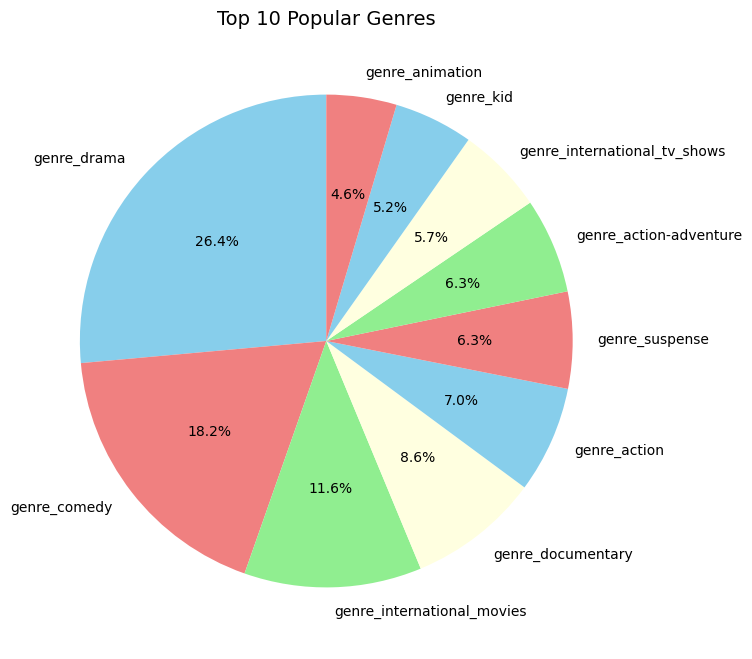

In [54]:
import difflib
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

# WordNetLemmatizer 초기화
lemmatizer = WordNetLemmatizer()

# 유사한 장르를 그룹화하는 함수
def group_similar_genres(genres, threshold=0.8):
    unique_genres = list(set(genres))  # 고유한 장르 목록
    grouped_genres = {}

    for genre in unique_genres:
        # 복수형을 단수형으로 변환
        genre_singular = lemmatizer.lemmatize(genre.lower())
        matched = False
        for key in grouped_genres:
            # 유사도 계산 (difflib)
            similarity = difflib.SequenceMatcher(None, genre_singular, key.lower()).ratio()
            if similarity >= threshold:
                grouped_genres[key].append(genre)
                matched = True
                break
        if not matched:
            grouped_genres[genre_singular] = [genre]

    # 그룹화된 결과 반환
    return grouped_genres


combined_data['genres'] = combined_data['listed_in'].apply(lambda x: x.split(', ') if pd.notna(x) else [])

# 장르 목록을 combined_data에서 가져오는 예시 (combined_data['genres']에 장르 목록이 있다고 가정)
all_genres = [genre for genres in combined_data['genres'] for genre in genres]

# 유사한 장르명 그룹화
grouped_genres = group_similar_genres(all_genres, threshold=0.8)

# 원핫 인코딩 열을 만들 때, 그룹화된 장르명에 대해 원핫 인코딩을 적용
def generate_one_hot_encoding(df, grouped_genres):
    # 고유한 장르 그룹을 가져옴
    unique_genre_groups = list(grouped_genres.keys())

    # 원핫 인코딩 열 생성
    for genre_group in unique_genre_groups:
        column_name = f'genre_{genre_group.replace(" ", "_")}'
        df[column_name] = df['genres'].apply(
            lambda x: 1 if any(g.lower() in map(str.lower, grouped_genres[genre_group]) for g in x) else 0
        )

    return df


# 원본 데이터프레임에서 원핫 인코딩 적용
combined_data_with_one_hot = generate_one_hot_encoding(combined_data.copy(), grouped_genres)

# 장르별 등장 횟수를 계산 (원핫 인코딩된 열만 사용)
genre_counts = combined_data_with_one_hot[[
    f'genre_{group.replace(" ", "_")}' for group in grouped_genres.keys()
]].sum()

# 장르별 등장 횟수를 내림차순으로 정렬하고, 상위 4개 장르를 추출합니다.
top_10_genres = genre_counts.sort_values(ascending=False).head(4)

#가장 인기있는 장르 1~4위 추출
# 장르별 등장 횟수를 계산 (원핫 인코딩된 열만 사용)
genre_counts = combined_data_with_one_hot[[
    f'genre_{group.replace(" ", "_")}' for group in grouped_genres.keys()
]].sum()

# 장르별 등장 횟수를 내림차순으로 정렬하고, 상위 4개 장르를 추출합니다.
top_10_genres = genre_counts.sort_values(ascending=False).head(10)

# 원형 차트로 시각화
plt.figure(figsize=(8, 8))
top_10_genres.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen', 'lightyellow'], legend=False)
plt.title('Top 10 Popular Genres', fontsize=14)
plt.ylabel('')  # ylabel 제거

In [58]:
clean_df = combined_data_with_one_hot.drop(['listed_in'],axis =1)

#넷플릭스 + 디즈니 + 아마존 전체 데이터의
#제작 상위 5개 국가 및 그 국가들이 만든 상위 3개의 장르

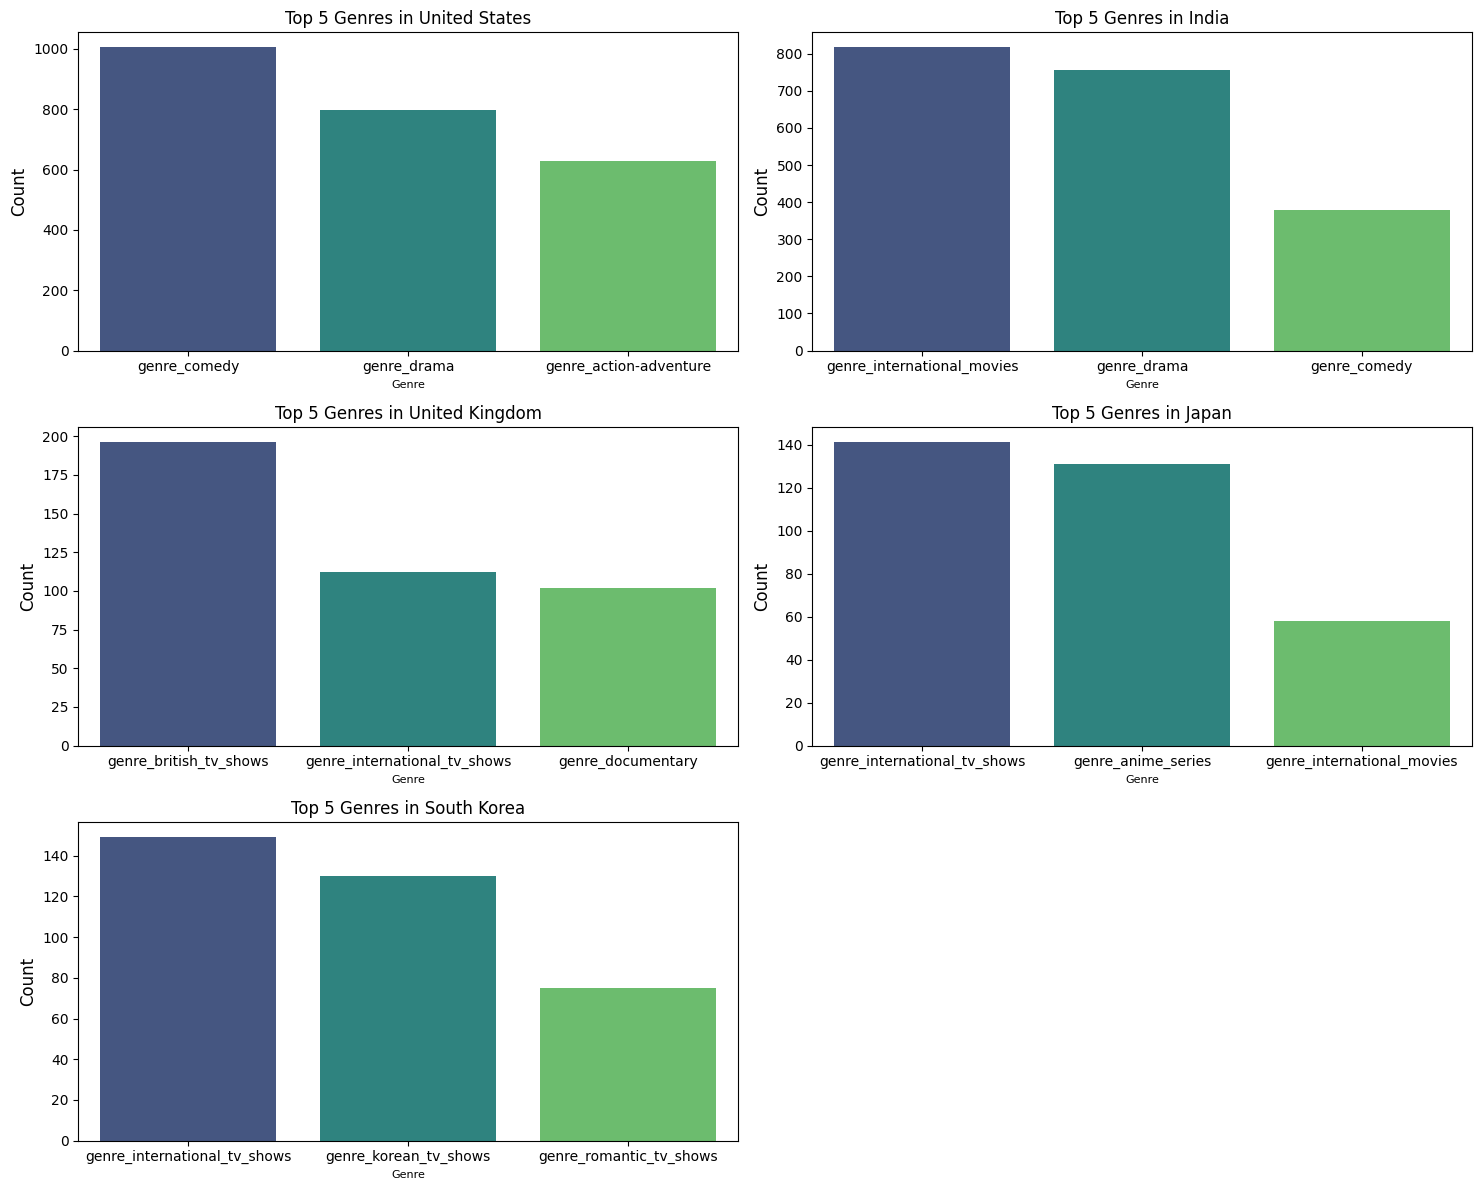


United States:
  genre_action-adventure: 630.0
  genre_comedy: 1005.0
  genre_drama: 799.0

India:
  genre_comedy: 378.0
  genre_drama: 755.0
  genre_international_movies: 817.0

United Kingdom:
  genre_british_tv_shows: 196.0
  genre_documentary: 102.0
  genre_international_tv_shows: 112.0

Japan:
  genre_anime_series: 131.0
  genre_international_movies: 58.0
  genre_international_tv_shows: 141.0

South Korea:
  genre_international_tv_shows: 149.0
  genre_korean_tv_shows: 130.0
  genre_romantic_tv_shows: 75.0


In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# 'genre_'로 시작하는 컬럼 선택
genre_columns = [col for col in clean_df.columns if col.startswith('genre_')]

# 국가별 장르 분포 계산
country_genre = clean_df.groupby('country')[genre_columns].sum()

# 국가별 장르 합계 계산 및 상위 5개 국가 선택
country_genre['total'] = country_genre.sum(axis=1)
top_countries = country_genre.nlargest(5, 'total').index
top_country_genre = country_genre.loc[top_countries].drop(columns='total')

# 각 국가별 상위 3개 장르 선택 및 결과 저장
result = {}
for country in top_country_genre.index:
    top_genres = top_country_genre.loc[country].nlargest(3)
    result[country] = top_genres

# 결과를 데이터프레임으로 변환
result_df = pd.DataFrame(result)

# subplot 생성 (3행 2열)
num_cols = 2  # 열의 개수
num_rows = math.ceil(len(result_df.columns) / num_cols)  # 행의 개수 계산
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))  # figsize 조정

# subplot에 그래프 그리기
for i, country in enumerate(result_df.columns):
    row_idx = i // num_cols  # 행 인덱스 계산
    col_idx = i % num_cols  # 열 인덱스 계산
    ax = axes[row_idx, col_idx]  # 현재 subplot 선택

    country_data = result_df[country].dropna().sort_values(ascending=False)
    sns.barplot(x=country_data.index, y=country_data.values, hue=country_data.index, palette='viridis', legend=False, ax=ax)
    ax.set_title(f'Top 5 Genres in {country}', fontsize=12)
    ax.set_xlabel('Genre', fontsize=8)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='x')

# 사용하지 않는 subplot 숨기기
for i in range(len(result_df.columns), num_rows * num_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    fig.delaxes(axes[row_idx, col_idx])

plt.tight_layout()
plt.show()

for country in result_df.columns:
    print(f"\n{country}:")
    country_data = result_df[country].dropna()
    for genre, value in country_data.items():
        print(f"  {genre}: {value}")


#통합되어있는 자료를 각각의 플래폼으로 분리하는 코드

In [ ]:
#통합되어있는 자료를 각각의 플래폼으로 분리하는 코드
netflix_df = clean_df[clean_df['platform'] == 'netflix']
disney_df = clean_df[clean_df['platform'] == 'disney_plus']
amazon_df = clean_df[clean_df['platform'] == 'amazon_prime']

#넷플릭스 데이터의
#제작 상위 5개 국가 및 그 국가들이 만든 상위 3개의 장르
#그래프

In [ ]:
#넷플릭스
import matplotlib.pyplot as plt
import seaborn as sns

# 'genre_'로 시작하는 컬럼 선택
genre_columns = [col for col in netflix_df.columns if col.startswith('genre_')]

# 국가별 장르 분포 계산
country_genre = netflix_df.groupby('country')[genre_columns].sum()

# 국가별 장르 합계 계산 및 상위 5개 국가 선택
country_genre['total'] = country_genre.sum(axis=1)
top_countries = country_genre.nlargest(5, 'total').index
top_country_genre = country_genre.loc[top_countries].drop(columns='total')

# 각 국가별 상위 3개 장르 선택 및 결과 저장
result = {}
for country in top_country_genre.index:
    top_genres = top_country_genre.loc[country].nlargest(3)
    result[country] = top_genres

# 결과를 데이터프레임으로 변환
result_df = pd.DataFrame(result)

# subplot 생성 (3행 2열)
num_cols = 2  # 열의 개수
num_rows = math.ceil(len(result_df.columns) / num_cols)  # 행의 개수 계산
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))  # figsize 조정

# subplot에 그래프 그리기
for i, country in enumerate(result_df.columns):
    row_idx = i // num_cols  # 행 인덱스 계산
    col_idx = i % num_cols  # 열 인덱스 계산
    ax = axes[row_idx, col_idx]  # 현재 subplot 선택

    country_data = result_df[country].dropna().sort_values(ascending=False)
    sns.barplot(x=country_data.index, y=country_data.values, hue=country_data.index, palette='viridis', legend=False, ax=ax)
    ax.set_title(f'Top 5 Genres in {country}', fontsize=12)
    ax.set_xlabel('Genre', fontsize=8)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='x')

# 사용하지 않는 subplot 숨기기
for i in range(len(result_df.columns), num_rows * num_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    fig.delaxes(axes[row_idx, col_idx])

plt.tight_layout()
plt.show()

for country in result_df.columns:
    print(f"\n{country}:")
    country_data = result_df[country].dropna()
    for genre, value in country_data.items():
        print(f"  {genre}: {value}")

#디즈니 데이터의
#제작 상위 5개 국가 및 그 국가들이 만든 상위 3개의 장르
#그래프

In [ ]:
#디즈니
import matplotlib.pyplot as plt
import seaborn as sns

# 'genre_'로 시작하는 컬럼 선택
genre_columns = [col for col in disney_df.columns if col.startswith('genre_')]

# 국가별 장르 분포 계산
country_genre = disney_df.groupby('country')[genre_columns].sum()

# 국가별 장르 합계 계산 및 상위 5개 국가 선택
country_genre['total'] = country_genre.sum(axis=1)
top_countries = country_genre.nlargest(5, 'total').index
top_country_genre = country_genre.loc[top_countries].drop(columns='total')

# 각 국가별 상위 3개 장르 선택 및 결과 저장
result = {}
for country in top_country_genre.index:
    top_genres = top_country_genre.loc[country].nlargest(3)
    result[country] = top_genres

# 결과를 데이터프레임으로 변환
result_df = pd.DataFrame(result)

# subplot 생성 (3행 2열)
num_cols = 2  # 열의 개수
num_rows = math.ceil(len(result_df.columns) / num_cols)  # 행의 개수 계산
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))  # figsize 조정

# subplot에 그래프 그리기
for i, country in enumerate(result_df.columns):
    row_idx = i // num_cols  # 행 인덱스 계산
    col_idx = i % num_cols  # 열 인덱스 계산
    ax = axes[row_idx, col_idx]  # 현재 subplot 선택

    country_data = result_df[country].dropna().sort_values(ascending=False)
    sns.barplot(x=country_data.index, y=country_data.values, hue=country_data.index, palette='viridis', legend=False, ax=ax)
    ax.set_title(f'Top 5 Genres in {country}', fontsize=12)
    ax.set_xlabel('Genre', fontsize=8)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='x')

# 사용하지 않는 subplot 숨기기
for i in range(len(result_df.columns), num_rows * num_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    fig.delaxes(axes[row_idx, col_idx])

plt.tight_layout()
plt.show()

for country in result_df.columns:
    print(f"\n{country}:")
    country_data = result_df[country].dropna()
    for genre, value in country_data.items():
        print(f"  {genre}: {value}")

#아마존 전체 데이터의
#제작 상위 5개 국가 및 그 국가들이 만든 상위 3개의 장르
#그래프

In [ ]:
#아마존
import matplotlib.pyplot as plt
import seaborn as sns

# 'genre_'로 시작하는 컬럼 선택
genre_columns = [col for col in amazon_df.columns if col.startswith('genre_')]

# 국가별 장르 분포 계산
country_genre = amazon_df.groupby('country')[genre_columns].sum()

# 국가별 장르 합계 계산 및 상위 5개 국가 선택
country_genre['total'] = country_genre.sum(axis=1)
top_countries = country_genre.nlargest(5, 'total').index
top_country_genre = country_genre.loc[top_countries].drop(columns='total')

# 각 국가별 상위 3개 장르 선택 및 결과 저장
result = {}
for country in top_country_genre.index:
    top_genres = top_country_genre.loc[country].nlargest(3)
    result[country] = top_genres

# 결과를 데이터프레임으로 변환
result_df = pd.DataFrame(result)

# subplot 생성 (3행 2열)
num_cols = 2  # 열의 개수
num_rows = math.ceil(len(result_df.columns) / num_cols)  # 행의 개수 계산
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))  # figsize 조정

# subplot에 그래프 그리기
for i, country in enumerate(result_df.columns):
    row_idx = i // num_cols  # 행 인덱스 계산
    col_idx = i % num_cols  # 열 인덱스 계산
    ax = axes[row_idx, col_idx]  # 현재 subplot 선택

    country_data = result_df[country].dropna().sort_values(ascending=False)
    sns.barplot(x=country_data.index, y=country_data.values, hue=country_data.index, palette='viridis', legend=False, ax=ax)
    ax.set_title(f'Top 5 Genres in {country}', fontsize=12)
    ax.set_xlabel('Genre', fontsize=8)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='x')

# 사용하지 않는 subplot 숨기기
for i in range(len(result_df.columns), num_rows * num_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    fig.delaxes(axes[row_idx, col_idx])

plt.tight_layout()
plt.show()

for country in result_df.columns:
    print(f"\n{country}:")
    country_data = result_df[country].dropna()
    for genre, value in country_data.items():
        print(f"  {genre}: {value}")

## OTT 플랫폼별 제작국가와 장르의 상관관계 분석
1. 데이터 분석처리 과정
- 장르의 종류 축소 1330가지의 장르 >> 90개로 축소(비슷한 장르를 하나로 묶는작업)
- 통합되어있는 자료의 상위 5개 국가 추출, 그 국가들의 상위 3개의 장르 추출후 그래프화
- 통화되어 있는 자료 넷플릭스, 디즈니, 아마존으로 세분화 작업후 그래프화

2. 분석된 데이터 및 그래프가 말하는 내용
1등 미국은 코미디, 드라마, 어드벤쳐 순으로 많은 영상을 제작
2등 인도는 인터네셔널영화, 드라마, 코미디 순으로 많은 영상을 제작
3,4,5등 영국, 일본, 한국은 TV쇼를 위주로 제작을 했다는것을 알수 있었다.

3. 해당 내용이 우리의 타겟에게 어필할 수 있는것
많이 만든다고 반드시 흥행한다는 것은 아니지만 투자를 받아야 제작이 가능하다는것을 전제하에 한국의 경우 TV쇼에 너무 국한된 느낌이 보여서 코미디, 드라마 제작 비중을 늘려가는것이 투자자의 관점에서 좀더 매력적으로 보일수 있을것 같다.

|플래폼|넷플릭스|디즈니|아마존|
|--|--|--|--|

##플램폼 통합 순위
1. 미국:
  1. 코미디: 1005.0
  2. 드라마: 799.0
  3. 액션-어드벤쳐: 630.0
  
2. 인도:
  1. 인터네셔널 영화: 817.0
  2. 드라마: 755.0
  3. 코미디: 378.0
  
3. 영국:
  1. 영국 tv 쇼: 196.0
  2. 인터네셔널 TV쇼: 112.0
  3. 다큐멘터리: 102.0
  
4. 일본:
  1. 인터네셔널 TV쇼: 141.0
  2. 애니메이션 시리즈: 131.0
  3. 인터네셔널 영화: 58.0
  
5. 한국:
  1. 인터네셔널 TV쇼: 149.0
  2. 한국 TV 쇼: 130.0
  3. 로맨틱 TV 쇼: 75.0
-----------------------------------------------------------------
##넷플릭스
1. 미국:
  1. 드라마: 591.0
  2. 코미디: 524.0
  3. 다큐멘터리: 411.0
  
2. 인도:
  1. 인터네셔널 영화: 817.0
  2. 드라마: 620.0
  3. 코미디: 308.0
  
3. 영국:
  1. 영국 tv 쇼: 196.0
  2. 인터네셔널 TV쇼: 112.0
  3. 다큐멘터리: 84.0
  
4. 일본:
  1. 인터네셔널 TV쇼: 141.0
  2. 애니메이션 시리즈: 131.0
  3. 인터네셔널 영화: 58.0
  
5. 한국:
  1. 인터네셔널 TV쇼: 149.0
  2. 한국 TV 쇼: 130.0
  3. 로맨틱 TV 쇼: 75.0
--------------------------------------------------------------------
##디즈니
1. 미국:
  1. 가족: 501.0
  2. 코미디: 412.0
  3. 애니메이션: 403.0
    
2. 미국, 캐나다:
  1. 코미디: 16.0
  2. 액션-어드벤쳐: 11.0
  3. 판타지: 9.0

3. 미국, 영국:
  1. 가족: 14.0
  2. 액션-어드벤쳐: 11.0
  3. 코미디: 7.0
  
4. 영국:
  1. genre_docuseries: 11.0
  2. 다큐멘터리: 8.0
  3. 역사: 8.0

5. 캐나다, 미국:
  1. 코미디: 7.0
  2. genre_coming_of_age: 6.0
  3. 드라마: 6.0
---------------------------------------------------------
##아마존

1. 인도:
  1. 드라마: 135.0
  2. 코미디: 70.0
  3. genre_international: 128.0

2. 미국:
  1. 드라마: 109.0
  2. 코미디: 69.0
  3. 서스펜스: 55.0

3. 영국:
  1. 다큐멘터리: 10.0
  2. 코미디: 5.0
  3. 드라마: 5.0

4. 캐나다:
  1. 다큐멘터리: 7.0
  2. 드라마: 5.0
  3. genre_special_interest: 4.0

5. 영국, 미국:
  1. 드라마: 6.0
  2. 코미디: 5.0
  3. 액션: 3.0
--------------------------------------------------------------------------------

